In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
#from gprofiler import GProfiler
#import loompy as lp
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
#from rpy2.robjects import pandas2ri
#import anndata2ri
import warnings
warnings.filterwarnings('ignore')
import scipy 

In [2]:
import os              
os.environ['PYTHONHASHSEED'] = '0'

In [3]:
sc.settings.set_figure_params(dpi=100, facecolor='white')

In [4]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA

In [5]:
from kneed import KneeLocator as kl

#### Data Import

In [6]:
adataM4 = sc.read("/mnt/lugli/spuccio/SP025_NaClTcell/singlecell/Analysis/Mouse4QC.h5ad")
adataM5 = sc.read("/mnt/lugli/spuccio/SP025_NaClTcell/singlecell/Analysis/Mouse5QC.h5ad")
adataM25 = sc.read("/mnt/lugli/spuccio/SP025_NaClTcell/singlecell/Analysis/Mouse25QC.h5ad")
adataM32 = sc.read("/mnt/lugli/spuccio/SP025_NaClTcell/singlecell/Analysis/Mouse32QC.h5ad")

In [7]:
adata = adataM4.concatenate(adataM5, adataM25,adataM32)

In [8]:
adata.X = scipy.sparse.csr_matrix.todense(adata.X)

In [9]:
adata.raw = adata

In [10]:
adata.shape

(37428, 16675)

In [11]:
del adataM4
del adataM5
del adataM25
del adataM32

#### Normalize counts to 10.000 reads x cells

In [12]:
norm_data = adata.copy()

In [13]:
sc.pp.normalize_total(norm_data, target_sum=1e4)

In [14]:
adata.layers['norm_data'] = norm_data.X.copy()

#### log n+1 transform

In [15]:
sc.pp.log1p(norm_data)

In [16]:
adata.layers['log1p'] = norm_data.X

#### identify higly variable genes

In [17]:
adata.layers

Layers with keys: raw_counts, norm_data, log1p

In [18]:
sc.pp.highly_variable_genes(adata,layer="log1p")

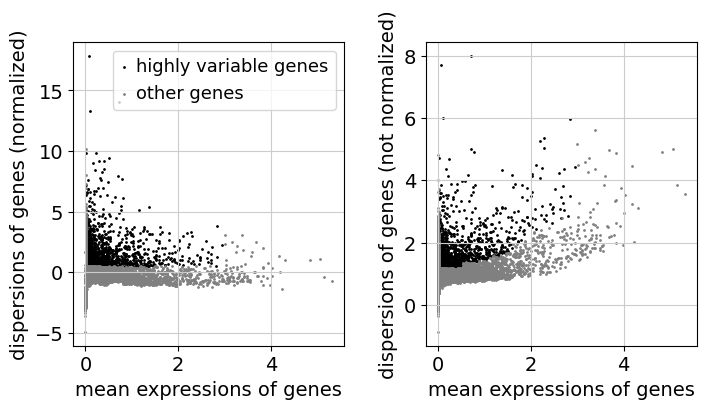

In [19]:
sc.pl.highly_variable_genes(adata)

#### Perform scaling 

In [20]:
adata.layers['scaled'] = sc.pp.scale(adata, max_value=10, layer="log1p",copy=True).layers['log1p']

#### Cell Cycle Score

In [21]:
cell_cycle_genes = [x.strip() for x in open('/mnt/lugli/spuccio/SP025_NaClTcell/singlecell/Analysis/regev_lab_cell_cycle_genes.txt')]

In [22]:
s_genes = cell_cycle_genes[:40]
g2m_genes = cell_cycle_genes[40:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [23]:
adata_cc_genes = adata.copy()

In [24]:
adata_cc_genes.raw = adata_cc_genes

In [25]:
adata_cc_genes = sc.tl.score_genes_cell_cycle(adata_cc_genes, s_genes=["Mcm5","Pcna",'Tyms','Fen1','Mcm2','Mcm4','Rrm1','Ung','Gins2','Mcm6','Cdca7','Dtl','Prim1','Uhrf1','Hells','Rfc2','Rpa2','Nasp','Rad51ap1','Gmnn','Wdr76','Slbp','Ccne2','Ubr7','Msh2','Rad51','Rrm2','Cdc45','Cdc6','Exo1','Tipin','Dscc1','Blm','Casp8ap2','Usp1','Clspn','Pola1','Chaf1b','Brip1','E2f8'],
                             g2m_genes=['Hmgb2','Nusap1','Ube2c','Birc5','Tpx2','Top2a','Ndc80','Cks2','Nuf2','Cks1b','Cks1brt','Mki67','Cenpf','Tacc3','Pimreg','Smc4','Ccnb2','Ckap2l','Ckap2','Aurkb','Bub1','Kif11','Anp32e','Tubb4b','Gtse1','Kif20b','Hjurp','Cdca3','Cdc20','Ttk','Cdc25c','Kif2c','Rangap1','Ncapd2','Dlgap5','Cdca2','Cdca8','Ect2','Kif23','Hmmr','Aurka','Psrc1','Anln','Lbr','Ckap5','Cenpe','Ctcf','Nek2','G2e3','Cenpa'],
                                              use_raw=True,copy=True)

In [27]:
adata_cc_genes.X = adata_cc_genes.layers['scaled']

In [28]:
sc.tl.pca(adata_cc_genes,svd_solver='arpack',copy=False)

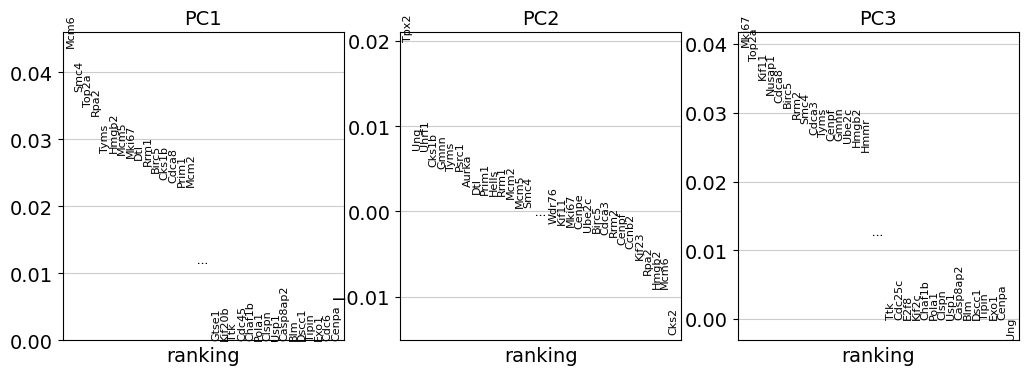

In [29]:
sc.pl.pca_loadings(adata_cc_genes[:, cell_cycle_genes])

... storing 'SampleID' as categorical
... storing 'Treatment' as categorical
... storing 'MouseID' as categorical
... storing 'phase' as categorical


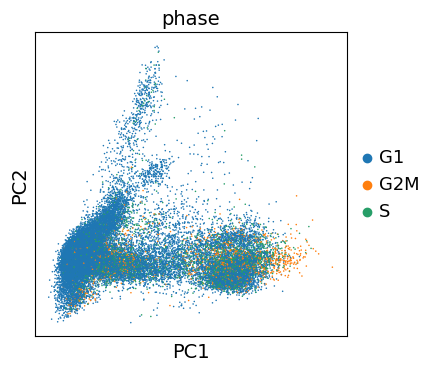

In [30]:
sc.pl.pca_scatter(adata_cc_genes, color='phase',s=5)

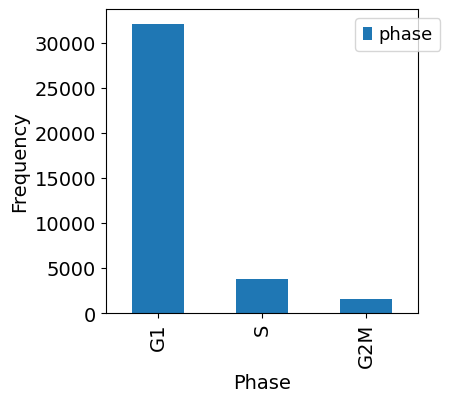

In [31]:
fig, (ax1) = plt.subplots(1,1)
ax1 = adata_cc_genes.obs["phase"].value_counts(normalize=False).plot.bar(legend=False,ax=ax1)
ax1.set_xlabel("Phase")
ax1.set_ylabel("Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

In [32]:
print(adata_cc_genes.obs["phase"].value_counts(normalize=True))
print(adata_cc_genes.obs["phase"].value_counts(normalize=False))

G1     0.856899
S      0.101127
G2M    0.041974
Name: phase, dtype: float64
G1     32072
S       3785
G2M     1571
Name: phase, dtype: int64


In [60]:
adata.obs = adata_cc_genes.obs

#### PCA

In [35]:
adata.X = adata.layers['scaled']

In [36]:
sc.tl.pca(adata,svd_solver='arpack',copy=False)

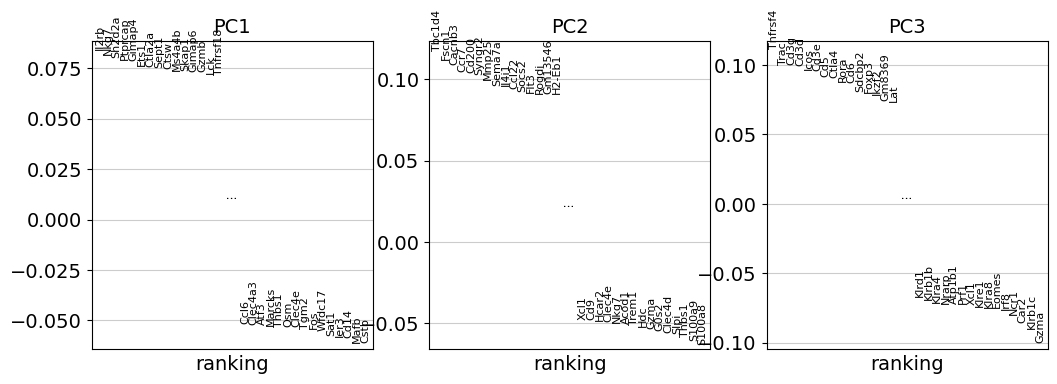

In [37]:
sc.pl.pca_loadings(adata)

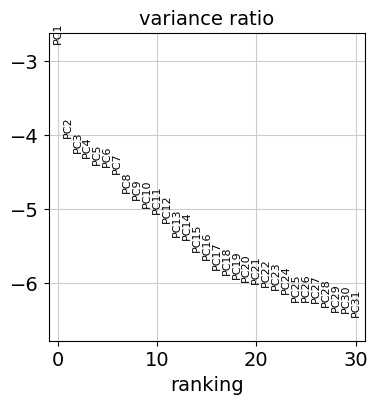

In [38]:
sc.pl.pca_variance_ratio(adata,log=True)

In [39]:
def PCA_elbox_fit(data):
    model = PCA().fit(data)
    explanied_variance = model.explained_variance_ratio_
    pcs = list(range(1,explanied_variance.shape[0]+1))
    klm = kl(pcs, explanied_variance,S=1.0, curve='convex',direction="decreasing")
    pcs_used = klm.knee
    pc_list = list(range(1,pcs_used+1))
    new_data = PCA(n_components=pcs_used,svd_solver="arpack").fit_transform(data)
    return pcs_used, new_data,pcs, explanied_variance,pc_list

In [40]:
HVG_data = adata[:,adata.var.highly_variable]

In [41]:
label = "HVG_data"

In [42]:
new_frame = pd.DataFrame(HVG_data.X.toarray(),index=HVG_data.obs_names,columns=HVG_data.var_names)

In [43]:
pandas_data = new_frame.values

In [44]:
dim,new_matrix, pc_ax,pc_ay,col_labels = PCA_elbox_fit(pandas_data)

In [45]:
print(dim)

25


In [46]:
columns = ["PC_"+str(i) for i in col_labels]

In [47]:
outputpath = "/mnt/lugli/spuccio/SP025_NaClTcell/singlecell/Analysis/"

In [48]:
PC_frame = pd.DataFrame(new_matrix, index=new_frame.index.values.tolist(),columns=columns)

In [49]:
PC_frame.shape

(37428, 25)

In [50]:
PC_frame.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23,PC_24,PC_25
AAACCCAAGACCATTC-1-0,-0.529738,-2.464511,-4.374427,0.106021,-0.271574,0.029662,1.249813,-5.845286,-0.459323,-0.475021,...,-0.083984,-0.812131,0.729025,0.839710,0.633153,-1.533822,-2.246245,1.710913,-1.058423,-2.992951
AAACCCAAGCCTAGGA-1-0,-2.715168,-2.404895,-2.505824,0.374704,0.973207,3.834173,-0.065727,-6.515939,-1.042865,-3.170193,...,0.397778,-0.645268,-0.522024,2.554834,3.313301,-0.714790,-1.298231,1.021685,-1.121909,-2.163584
AAACCCAAGGTAACTA-1-0,-3.814703,-1.229380,-2.196138,-0.045553,3.090857,0.198901,-1.168973,-0.209162,8.298322,-5.583841,...,-0.179550,1.401796,0.055031,-1.205461,1.838357,-1.632873,-3.618643,-2.354746,-0.772154,-0.889044
AAACCCACACAAGCTT-1-0,-7.689332,-3.130540,4.006817,-0.760313,-1.579211,1.677310,-0.179642,4.406479,-5.185390,-2.430861,...,-1.455636,2.404579,-2.288385,-2.263862,1.880693,0.426295,1.702325,-1.939560,1.336078,0.774368
AAACCCACAGAAGTTA-1-0,-7.600913,-3.288781,1.583280,0.073671,0.852165,-0.044853,-1.396238,0.750017,-4.777724,8.472054,...,0.396907,0.748504,0.366726,-0.609977,0.651771,0.627965,-0.961538,-1.260706,-1.069089,0.471615


Text(0, 0.5, 'Explained variance Ratio')

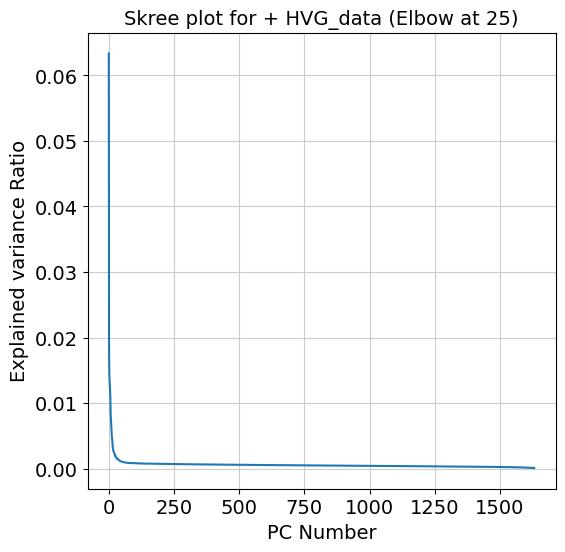

In [51]:
fig = plt.figure(figsize = (6,6,))
ax1 = fig.add_subplot(111)
ax1.set_title("Skree plot for + "+label+" (Elbow at "+str(dim)+")")
ax1.plot(pc_ax,pc_ay)
ax1.set_xlabel("PC Number")
ax1.set_ylabel("Explained variance Ratio")


In [52]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=dim)

In [53]:
sc.tl.umap(adata)

In [66]:
adata.write("/mnt/lugli/spuccio/SP025_NaClTcell/singlecell/Analysis/cluster_preparation.h5ad")

In [56]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

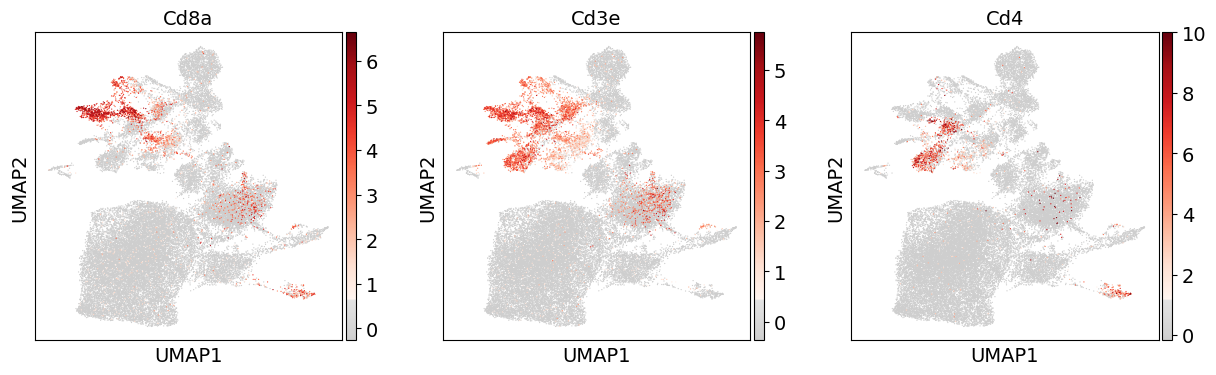

In [65]:
sc.pl.umap(adata,layer='scaled',color=['Cd8a','Cd3e','Cd4'],color_map=mymap)

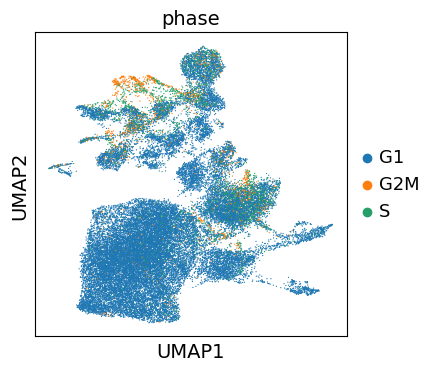

In [61]:
sc.pl.umap(adata,layer='scaled',color=['phase'])